In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge, SGDRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor

df = pd.read_csv('data/Beach6_2019_calibration_data.csv')
df['TURB_NTRU'] = np.log10(df['TURB_NTRU'])
df['AirportRain48W_in'] = np.sqrt(df['AirportRain48W_in'])
X = df.drop(columns=["DATE", "ECOLI_LOG10"])
y = df['ECOLI_LOG10']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # negative MSE
scoring = {"rmse": rmse_scorer, "r2": "r2"}

In [2]:
ridge_baseline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=42))
])

# Cross-val on the TRAIN split only
cv_r2  = cross_val_score(ridge_baseline, X_train, y_train, cv=cv, scoring="r2")
cv_mse = -cross_val_score(ridge_baseline, X_train, y_train, cv=cv, scoring="neg_mean_squared_error")
cv_rmse = np.sqrt(cv_mse)

print("Baseline Ridge — CV R2:", cv_r2.mean(), "±", cv_r2.std())
print("Baseline Ridge — CV RMSE (log10):", np.sqrt(cv_mse).mean(), "±", np.sqrt(cv_mse).std())

Baseline Ridge — CV R2: 0.4278664964584335 ± 0.10348862998276338
Baseline Ridge — CV RMSE (log10): 0.5031956693752581 ± 0.030439810478893155


In [3]:
# SGD (L1/L2/ElasticNet)
pipe_sgd = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("sgd", SGDRegressor(random_state=42, max_iter=3000))
])
grid_sgd = {
    "sgd__penalty": ["l2", "l1", "elasticnet"],
    "sgd__alpha":   [1e-5, 3e-5, 1e-4, 3e-4, 1e-3],
    "sgd__l1_ratio": [0.15, 0.5, 0.9]  # only used for elasticnet
}

# Linear: Ridge
pipe_ridge = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("ridge", Ridge(random_state=42))
])
grid_ridge = {"ridge__alpha": [0.03, 0.1, 0.3, 1, 3, 10, 30, 100]}

# Linear: Lasso
pipe_lasso = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("lasso", Lasso(random_state=42, max_iter=20000))
])
grid_lasso = {
    "lasso__alpha": [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 1.0]
}

# Polynomial regression: degree=2 + Ridge
pipe_poly_ridge = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ("ridge", Ridge(random_state=42))
])
grid_poly_ridge = {
    "poly__degree": [1, 2],  # 1 = baseline linear; 2 = squares + interactions
    "ridge__alpha": [0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
}

In [4]:
def run_grid(name, pipe, grid):
    gs = GridSearchCV(pipe, grid, cv=cv, scoring=scoring, refit="r2", n_jobs=-1, verbose=0)
    gs.fit(X_train, y_train)
    return name, gs.best_estimator_, pd.DataFrame(gs.cv_results_)

results = []
for name, pipe, grid in [
    ("SGD", pipe_sgd, grid_sgd),
    ("Ridge", pipe_ridge, grid_ridge),
    ("Lasso", pipe_lasso, grid_lasso),
    ("PolyRidge", pipe_poly_ridge, grid_poly_ridge)
]:
    results.append(run_grid(name, pipe, grid))

# unpack
models = {name: est for (name, est, df) in results}
cv_tables = {name: df for (name, est, df) in results}

In [5]:
def summarize(name, model):
    # CV on train
    cv_r2  = cross_val_score(model, X_train, y_train, cv=cv, scoring="r2")
    cv_mse = -cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_squared_error")
    cv_rmse = np.sqrt(cv_mse)

    # Test (log10)
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)
    test_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
    test_r2_log   = r2_score(y_test, y_pred_log)

    return {
        "model": name,
        "cv_r2_mean": float(cv_r2.mean()), "cv_r2_std": float(cv_r2.std()),
        "cv_rmse_log10_mean": float(cv_rmse.mean()), "cv_rmse_log10_std": float(cv_rmse.std()),
        "test_r2_log10": float(test_r2_log), "test_rmse_log10": float(test_rmse_log)
    }

rows = [summarize(n, m) for n, m in models.items()]
cmp = pd.DataFrame(rows).sort_values("cv_r2_mean", ascending=False)
display(cmp)

,model,cv_r2_mean,cv_r2_std,cv_rmse_log10_mean,cv_rmse_log10_std,test_r2_log10,test_rmse_log10
1,Ridge,0.429214,0.090411,0.503265,0.025849,0.488726,0.443116
3,PolyRidge,0.429214,0.090411,0.503265,0.025849,0.488726,0.443116
0,SGD,0.428330,0.102910,0.502999,0.030105,0.488516,0.443207
2,Lasso,0.428172,0.097413,0.503396,0.028589,0.489127,0.442942


In [6]:
def print_best_from_models(models):
    if "Ridge" in models:
        r = models["Ridge"].named_steps["ridge"]
        print(f"Ridge: alpha={r.alpha}")

    if "Lasso" in models:
        l = models["Lasso"].named_steps["lasso"]
        print(f"Lasso: alpha={l.alpha}")

    if "SGD" in models:
        s = models["SGD"].named_steps["sgd"]
        # l1_ratio is only relevant when penalty='elasticnet'
        print(f"SGD: penalty={s.penalty}, alpha={s.alpha}, l1_ratio={getattr(s, 'l1_ratio', None)}")

    if "PolyRidge" in models:
        pr = models["PolyRidge"]
        deg = pr.named_steps["poly"].degree
        a   = pr.named_steps["ridge"].alpha
        print(f"PolyRidge: degree={deg}, ridge__alpha={a}")

print_best_from_models(models)

Ridge: alpha=30
Lasso: alpha=0.01
SGD: penalty=l1, alpha=0.001, l1_ratio=0.15
PolyRidge: degree=1, ridge__alpha=30


In [7]:
candidates = ["SGD", "Ridge", "Lasso", "PolyRidge"]

best = cmp[cmp["model"].isin(candidates)].sort_values("cv_r2_mean", ascending=False).iloc[0]["model"]
print("Best model (by CV R2):", best)

Best model (by CV R2): Ridge


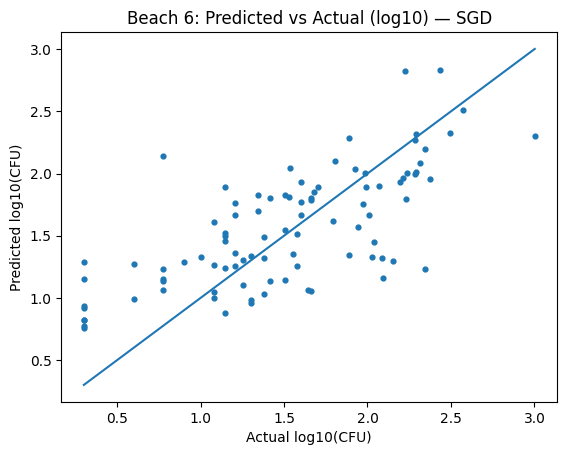

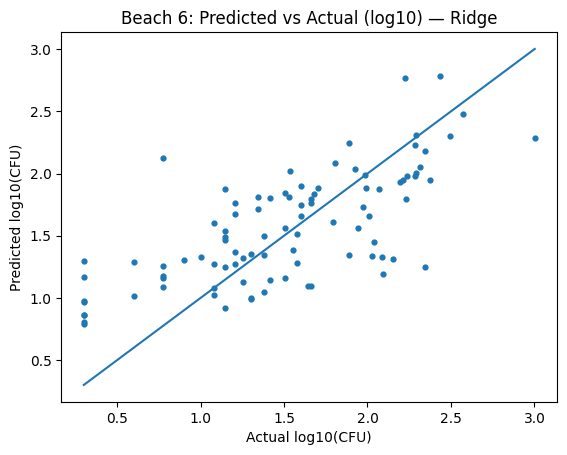

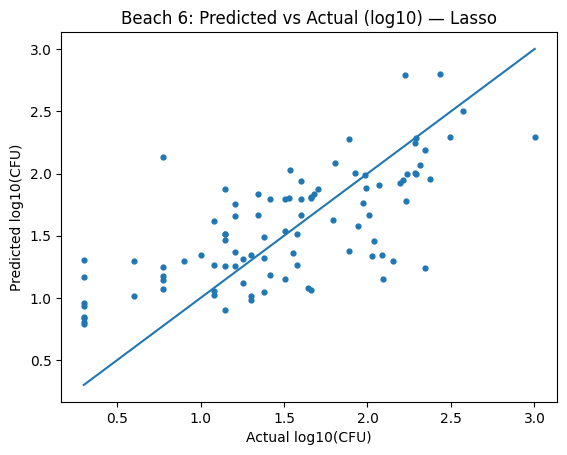

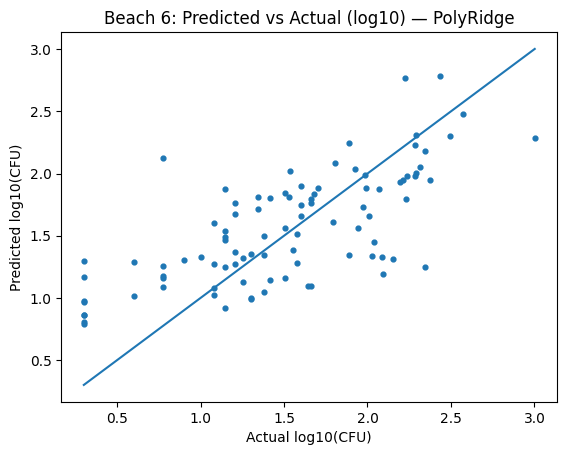

In [9]:
import matplotlib.pyplot as plt

def pred_vs_actual_plot(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    fig = plt.figure()
    plt.scatter(y_test, y_pred, s=12)
    lo, hi = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi])
    plt.title(f"Beach 6: Predicted vs Actual (log10) — {name}")
    plt.xlabel("Actual log10(CFU)"); plt.ylabel("Predicted log10(CFU)")
    plt.show()

for name, model in models.items():
    pred_vs_actual_plot(name, model)

In [10]:
%pip install -q statsmodels

Note: you may need to restart the kernel to use updated packages.


In [11]:
import statsmodels.api as sm

# Fit OLS with intercept on LOG10 target
Xc = sm.add_constant(X)
ols = sm.OLS(y, Xc, missing="drop").fit()

# Export parameter table and topline metrics
param_table = pd.DataFrame({
    "Coefficient": ols.params,
    "StdError":    ols.bse,
    "tStatistic":  ols.tvalues,
    "PValue":      ols.pvalues
})
param_table.index.name = "Parameter"

rmse_log10 = float(np.sqrt(ols.mse_resid))
topline = pd.Series({
    "Winner": "Ridge",
    "R2": ols.rsquared,
    "Adj_R2": ols.rsquared_adj,
    "RMSE_log10": rmse_log10,
    "AIC": ols.aic,
    "BIC": ols.bic,
})

# Full statsmodels summary
print(ols.summary())

# Neat pandas displays
with pd.option_context("display.float_format", "{:.6g}".format):
    print("\n OLS Parameters (coef / SE / t / p)")
    display(param_table)
    print("\n Topline Metrics (log10)")
    display(topline.to_frame("value"))

                            OLS Regression Results                            
Dep. Variable:            ECOLI_LOG10   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     59.18
Date:                Fri, 26 Sep 2025   Prob (F-statistic):           4.16e-60
Time:                        10:29:53   Log-Likelihood:                -317.22
No. Observations:                 463   AIC:                             650.4
Df Residuals:                     455   BIC:                             683.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.00

,Coefficient,StdError,tStatistic,PValue
Parameter,,,,
const,-1.00383,0.21202,-4.73461,2.9361e-06
TURB_NTRU,0.678792,0.0532315,12.7517,4.68357e-32
RHUM_PCT,0.0078567,0.00197429,3.9795,8.03508e-05
WTEMP_CEL,0.0526365,0.00740339,7.10977,4.52923e-12
BIRDS_NO,0.00180221,0.000733734,2.45622,0.0144134
CHANGELL_FT,0.32025,0.102557,3.12266,0.00190653
AirportWindSpInst_mph,0.0248327,0.00593142,4.18664,3.40009e-05
AirportRain48W_in,0.198572,0.0570778,3.47898,0.000551772



 Topline Metrics (log10)


,value
Winner,Ridge
R2,0.476576
Adj_R2,0.468524
RMSE_log10,0.48428
AIC,650.432
BIC,683.533


In [12]:
# Extract coefficients from the tuned Ridge model
ridge_model = models["Ridge"]   # this is the best_estimator_ from GridSearchCV

# Fit on full training data
ridge_model.fit(X_train, y_train)

# Get coefficients from the Ridge step inside the pipeline
ridge_coefs = ridge_model.named_steps["ridge"].coef_
ridge_intercept = ridge_model.named_steps["ridge"].intercept_

# Build a tidy table
ridge_coef_table = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": ridge_coefs
}).sort_values("Coefficient", key=abs, ascending=False)

print(f"Intercept: {ridge_intercept:.4f}")
display(ridge_coef_table)

Intercept: 1.5090


,Feature,Coefficient
0,TURB_NTRU,0.292572
2,WTEMP_CEL,0.160584
6,AirportRain48W_in,0.097703
1,RHUM_PCT,0.095856
5,AirportWindSpInst_mph,0.086368
4,CHANGELL_FT,0.076924
3,BIRDS_NO,0.056863


In [13]:
# Fit tuned Ridge model
ridge_model = models["Ridge"]
ridge_model.fit(X_train, y_train)

# Predictions on test
y_pred = ridge_model.predict(X_test)

# Compute differences
diffs = y_pred - y_test
abs_diffs = np.abs(diffs)

# Build error DataFrame including feature values
ridge_errors = X_test.copy()
ridge_errors["Actual"] = y_test
ridge_errors["Predicted"] = y_pred
ridge_errors["Difference"] = diffs
ridge_errors["AbsDifference"] = abs_diffs

# Sort by largest error
ridge_errors_sorted = ridge_errors.sort_values("AbsDifference", ascending=False)

# Show top 10 rows with features + errors
print("Top 10 errors (with feature values) for tuned Ridge:")
display(ridge_errors_sorted.head(10))

# If you still want a NumPy matrix:
ridge_diff_matrix = ridge_errors_sorted.to_numpy()


Top 10 errors (with feature values) for tuned Ridge:


,TURB_NTRU,RHUM_PCT,WTEMP_CEL,BIRDS_NO,CHANGELL_FT,AirportWindSpInst_mph,AirportRain48W_in,Actual,Predicted,Difference,AbsDifference
299,1.283866,90,22.06,100,-0.049,3,0.754983,0.7782,2.126967,1.348767,1.348767
18,0.593286,63,18.39,13,0.220,10,0.100000,2.3424,1.249661,-1.092739,1.092739
172,0.718086,71,20.78,0,-0.027,5,0.141421,0.3010,1.296651,0.995651,0.995651
72,0.055951,67,22.39,60,-0.050,14,0.000000,2.0934,1.188631,-0.904769,0.904769
305,0.285557,77,22.44,1,0.003,7,0.000000,0.3010,1.172373,0.871373,0.871373
132,0.374748,77,21.67,95,0.000,5,0.000000,2.1523,1.316994,-0.835306,0.835306
173,0.819544,78,20.00,0,-0.131,5,0.100000,2.0864,1.331458,-0.754942,0.754942
168,1.053078,70,20.78,13,0.443,7,0.806226,1.1461,1.877987,0.731887,0.731887
101,1.826884,86,15.11,2,-0.203,14,1.545962,3.0017,2.288843,-0.712857,0.712857
196,0.676922,60,20.33,25,0.312,6,0.070711,2.0253,1.333772,-0.691528,0.691528
